# Data : SROIE dataset

> from ICDAR 2019 Robust Reading Challenge on Scanned Receipts OCR and Information Extraction



In [ ]:
#Download data
!gdown --id 1o94cggdq-p8TYyKnHq-TRj0vy32MDxBP
!unzip SROIE.zip && mkdir data && mv box data/box && mv img data/img && mv key data/key && rm -rf SROIE.zip

Downloading...
From: https://drive.google.com/uc?id=1o94cggdq-p8TYyKnHq-TRj0vy32MDxBP
To: /content/SROIE.zip
355MB [00:09, 39.4MB/s]
Archive:  SROIE.zip
  inflating: img/483.jpg             
  inflating: img/113.jpg             
  inflating: img/036.jpg             
  inflating: img/385.jpg             
  inflating: img/012.jpg             
  inflating: key/544.json            
  inflating: img/510.jpg             
  inflating: img/143.jpg             
  inflating: img/046.jpg             
  inflating: img/314.jpg             
  inflating: box/364.csv             
  inflating: img/174.jpg             
  inflating: img/144.jpg             
  inflating: img/083.jpg             
  inflating: img/272.jpg             
  inflating: img/363.jpg             
  inflating: img/404.jpg             
  inflating: img/325.jpg             
  inflating: img/471.jpg             
  inflating: box/375.csv             
  inflating: img/276.jpg             
  inflating: key/589.json            
  inflating

#Preprocessing

## Definition of some functions

###Get the bounding box of each word

In [ ]:
def get_word_bbox(text,box):
  list=[]

  f=box[2]
  diff=int(box[2])-int(box[0])
  l=len(text)
  words=text.split(" ")
  for i in range(len(words)-1):
    dict={}
    d=len(words[i])
    box=[box[0],box[1],int(box[0]+diff*d/l),box[3]]
    dict["text"]=words[i]
    dict["box"]=box
    list.append(dict)
    box=[int(box[0]+diff*d/l+diff*1/l),box[1],int(box[0]+diff*d/l+diff*1/l),box[3]]
  dict={}
  d=len(words[len(words)-1])
  box=[box[0],box[1],f,box[3]]
  dict["text"]=words[len(words)-1]
  dict["box"]=box
  list.append(dict)
  return list

###Get the label of each word

In [ ]:
def get_label(text,file):

  with open(file, "r", encoding="utf8") as f:
                data = json.load(f)
  for i in data:
                  if len(re.findall("\d+/\d+/\d+",text))!=0 :
                     text=re.findall("\d+/\d+/\d+",text)[0]
                  elif len(re.findall("\d+-\d+-\d+",text))!=0 :
                     text=re.findall("\d+-\d+-\d+",text)[0]
                  elif len(re.findall("\d+\s+\w+\s+\d+",text))!=0 :
                     text=re.findall("\d+\s+\w+\s+\d+",text)[0]
                  elif len(re.findall("\d+-\w+-\d+",text))!=0 :
                     text=re.findall("\d+-\w+-\d+",text)[0]
                  elif len(re.findall("\d+/\w+/\d+",text))!=0 :
                     text=re.findall("\d+/\w+/\d+",text)[0]
                  if i=="total" and len(re.findall("\d+.\d+",text))!=0 :
                    if text==data[i] or text.rstrip(" RM ")==data[i] or text.lstrip(" RM ")==data[i] :
                      label=i
                      break
                  elif (text in data[i].replace(", ",",") or text in data[i] or text.rsplit(' ',1)[0]==data[i] or text.rsplit(' ',2)[0]==data[i]) and len(text)>= 3 :
                      label=i
                      break
                  else :
                      label="other"
  return label

###Create a JSON file that contains full annotations

In [ ]:
def create_annotation(file_path,jfile_path,output):
  import json
  dict={}
  dict["form"]=[]
  with open(file_path, "r", encoding="utf8") as fb :
    id=0
    for line in fb :
      dict1={}
      line_split = line.strip().split(",", maxsplit=8)
      box=[line_split[0],line_split[1],line_split[4],line_split[5]]
      box=[int(i) for i in box]
      text = line_split[8]
      dict1["box"]=box
      dict1["text"]=text
      dict1["label"]=get_label(text,jfile_path)
      dict1["words"]=get_word_bbox(text,box)
      dict1["id"]=id
      id+=1
      dict["form"].append(dict1)

  with open(output, 'w',encoding='utf-8') as outfile:
    json.dump(dict, outfile,ensure_ascii=False, indent=4)



## Create the annotations of all data

In [ ]:
import os
import re
import json
data_dir="data/box"
!mkdir data/annotations
for file in sorted(os.listdir(data_dir)):
           file_path = os.path.join(data_dir, file)
           jfile_path = file_path.replace("box", "key")
           jfile_path = jfile_path.replace("csv", "json")
           output=file_path.replace("box", "annotations")
           output=output.replace("csv", "json")
           create_annotation(file_path,jfile_path,output)


## Split data into a train set and test set

In [ ]:
import os
import random
import shutil
!mkdir data/train && mkdir data/test
!mkdir data/train/annotations && mkdir data/train/img && mkdir data/train/box && mkdir data/train/key
!mkdir data/test/annotations && mkdir data/test/img && mkdir data/test/box && mkdir data/test/key
random.seed(2)
#train ratio = 0.8
trainset=random.sample(range(626),500)
#test ratio = 0.2
testset=list(set(range(626))-set(trainset))
data_dir="data/annotations"
for file in sorted(os.listdir(data_dir)):
  file_path = os.path.join(data_dir, file)
  image_path = file_path.replace("annotations", "img")
  image_path = image_path.replace("json", "jpg")
  box_path=file_path.replace("annotations", "box")
  box_path = box_path.replace("json", "csv")
  key_path = file_path.replace("annotations", "key")
  if int(file.replace(".json", "")) in trainset:
    dest=shutil.copy(file_path,"data/train/annotations/")
    dest=shutil.copy(image_path,"data/train/img/")
    dest=shutil.copy(box_path,"data/train/box/")
    dest=shutil.copy(key_path,"data/train/key/")
  elif int(file.replace(".json", "")) in testset:
    dest=shutil.copy(file_path,"data/test/annotations/")
    dest=shutil.copy(image_path,"data/test/img/")
    dest=shutil.copy(box_path,"data/test/box/")
    dest=shutil.copy(key_path,"data/test/key/")

In [ ]:
#installation of transformers for tokenization
!pip install transformers


     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 890kB 17.3MB/s 
     |████████████████████████████████| 1.1MB 19.7MB/s 
     |████████████████████████████████| 3.0MB 30.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8311e64fa5d0c1a138f9a161d4c681b4c95dd7e0c5465b0e1cb0f8ee338f58c6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Create 3 input files in the form that the model accepts


1.   **Train.txt and test.txt**: contains the label of words ( examples : "YHM	B-COMPANY" )
2.   **Train_box.txt and test_box.txt** : contains words with their respective bounding boxes ( example : "JOHOR	408 172 444 185" )
3.   **Train_image.txt and  test_image.txt** : contains words with their repective image name (example : "YHM	1914 779 2637 865	4961 7016	305.jpg" )





In [ ]:
import argparse
import json
import os
import re
from PIL import Image
from transformers import AutoTokenizer


def bbox_string(box, width, length):
    return (
        str(int(1000 * (box[0] / width)))
        + " "
        + str(int(1000 * (box[1] / length)))
        + " "
        + str(int(1000 * (box[2] / width)))
        + " "
        + str(int(1000 * (box[3] / length)))
    )


def actual_bbox_string(box, width, length):
    return (
        str(box[0])
        + " "
        + str(box[1])
        + " "
        + str(box[2])
        + " "
        + str(box[3])
        + "\t"
        + str(width)
        + " "
        + str(length)
    )


def convert(output_dir,data_dir,data_split):
    with open(
        os.path.join(output_dir , data_split + ".txt.tmp"),
        "w",
        encoding="utf8",
    ) as fw, open(
        os.path.join(output_dir , data_split + "_box.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fbw, open(
        os.path.join(output_dir , data_split + "_image.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fiw:
        for file in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file)
            with open(file_path, "r", encoding="utf8") as f:
                data = json.load(f)
            image_path = file_path.replace("annotations", "img")
            image_path = image_path.replace("json", "jpg")
            file_name = os.path.basename(image_path)
            image = Image.open(image_path)
            width, length = image.size
            c=0
            s=0
            for item in data["form"]:
                words, label = item["words"], item["label"]
                words = [w for w in words if w["text"].strip() != ""]
                if len(words) == 0:
                    continue
                if label == "other":
                    for w in words:
                        fw.write(w["text"] + "\tO\n")
                        fbw.write(
                            w["text"]
                            + "\t"
                            + bbox_string(w["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            w["text"]
                            + "\t"
                            + actual_bbox_string(item["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
                elif label=="total":
                    if len(words) == 1:
                        fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                        fbw.write(
                            words[0]["text"]
                            + "\t"
                            + bbox_string(words[0]["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            words[0]["text"]
                            + "\t"
                            + actual_bbox_string(item["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
                    else:
                        for w in words:
                            if len(re.findall("\d+.\d+",w["text"]))!=0 :

                                fw.write(w["text"] + "\tB-" + label.upper() + "\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                            else :
                                fw.write(w["text"] + "\tO\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )

                elif label=="company":
                    if c==0:
                        if len(words) == 1:
                            fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                        else:
                            fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                            for w in words[1:]:
                              if w["text"][-1]==')' and w==words[-1]:
                                fw.write(w["text"] + "\tO\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                              else :
                                fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                        c+=1
                    else :
                        if len(words) == 1:
                            fw.write(words[0]["text"] + "\tI-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                        else:
                            fw.write(words[0]["text"] + "\tI-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                            for w in words[1:]:
                                fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(item["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                elif label=="address":
                    if s==0:
                        if len(words) == 1:
                            fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                        else:
                            fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                            for w in words[1:]:
                                fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                        s+=1

                    else :
                        if len(words) == 1:
                            fw.write(words[0]["text"] + "\tI-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                        else:
                            fw.write(words[0]["text"] + "\tI-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(item["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                            for w in words[1:]:
                                fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                elif label=="date":
                    if len(words) == 1:
                        fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                        fbw.write(
                            words[0]["text"]
                            + "\t"
                            + bbox_string(words[0]["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            words[0]["text"]
                            + "\t"
                            + actual_bbox_string(item["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
                    else:
                        x=0
                        while len(re.findall("^\d",words[x]["text"]))==0 and len(re.findall("^\[\d",words[x]["text"]))==0 :
                          fw.write(words[x]["text"] + "\tO\n")
                          fbw.write(
                                    words[x]["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                            )
                          fiw.write(
                                    words[x]["text"]
                                    + "\t"
                                    + actual_bbox_string(item["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                            )
                          #print(words[x]["text"] + "\tO\n")
                          x+=1
                          if x >= len(words):
                            break
                        if x <len(words):
                          fw.write(words[x]["text"] + "\tB-" + label.upper() + "\n")
                          fbw.write(
                                  words[x]["text"]
                                  + "\t"
                                  + bbox_string(words[x]["box"], width, length)
                                  + "\n"
                              )
                          fiw.write(
                                  words[x]["text"]
                                  + "\t"
                                  + actual_bbox_string(item["box"], width, length)
                                  + "\t"
                                  + file_name
                                  + "\n"
                              )
                          for w in words[x+1:]:
                            if len(re.findall("\d+:\d+",w["text"]))==0 and len(re.findall("^\(",w["text"]))==0 :
                                  fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                  fbw.write(
                                      w["text"]
                                      + "\t"
                                      + bbox_string(w["box"], width, length)
                                      + "\n"
                                  )
                                  fiw.write(
                                      w["text"]
                                      + "\t"
                                      + actual_bbox_string(item["box"], width, length)
                                      + "\t"
                                      + file_name
                                      + "\n"
                                  )
                            else :
                              fw.write(w["text"] + "\tO\n")
                              fbw.write(
                                      w["text"]
                                      + "\t"
                                      + bbox_string(w["box"], width, length)
                                      + "\n"
                              )
                              fiw.write(
                                      w["text"]
                                      + "\t"
                                      + actual_bbox_string(item["box"], width, length)
                                      + "\t"
                                      + file_name
                                      + "\n"
                              )
                              break
            fw.write("\n")
            fbw.write("\n")
            fiw.write("\n")







def seg_file(file_path, tokenizer, max_len):
    subword_len_counter = 0
    output_path = file_path[:-4]
    with open(file_path, "r", encoding="utf8") as f_p, open(
        output_path, "w", encoding="utf8"
    ) as fw_p:
        for line in f_p:
            line = line.rstrip()

            if not line:
                fw_p.write(line + "\n")
                subword_len_counter = 0
                continue
            token = line.split("\t")[0]

            current_subwords_len = len(tokenizer.tokenize(token))

            # Token contains strange control characters like \x96 or \x95
            # Just filter out the complete line
            if current_subwords_len == 0:
                continue

            if (subword_len_counter + current_subwords_len) > max_len:
                fw_p.write("\n" + line + "\n")
                subword_len_counter = current_subwords_len
                continue

            subword_len_counter += current_subwords_len

            fw_p.write(line + "\n")


def seg(model_name_or_path,output_dir,max_len,data_split):
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, do_lower_case=True)
    seg_file(
        os.path.join(output_dir, data_split + ".txt.tmp"),
        tokenizer,
        max_len,
    )
    seg_file(
        os.path.join(output_dir, data_split + "_box.txt.tmp"),
        tokenizer,
        max_len,
    )
    seg_file(
        os.path.join(output_dir, data_split + "_image.txt.tmp"),
        tokenizer,
        max_len,
    )



Creation of train.txt , train_box.txt and train_image.txt

In [ ]:
data_dir="data/train/annotations"
data_split="train"
output_dir="data/"
model_name_or_path="bert-base-uncased"
max_len=512
convert(output_dir,data_dir,data_split)
seg(model_name_or_path,output_dir,max_len,data_split)


Creation of test.txt , test_box.txt and test_image.txt

In [ ]:
data_dir="data/test/annotations"
data_split="test"
output_dir="data/"
model_name_or_path="bert-base-uncased"
max_len=512
convert(output_dir,data_dir,data_split)
seg(model_name_or_path,output_dir,max_len,data_split)

Create a file labels.txt that contains all possible labels ( e.g : B-company , I-company , B-address , I-address , B-date , B-Total , O (other) )

In [ ]:
%cd "data/"

/content/data


In [ ]:
!cat train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > labels.txt

#Modeling

## Cloning the github repository and insatlling the requirements

In [ ]:
%cd /content

/content


In [ ]:
!git clone https://github.com/microsoft/unilm

Cloning into 'unilm'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 737 (delta 0), reused 0 (delta 0), pack-reused 733
Receiving objects: 100% (737/737), 421.16 KiB | 599.00 KiB/s, done.
Resolving deltas: 100% (404/404), done.


In [ ]:
cd /content/unilm/layoutlm/

/content/unilm/layoutlm


In [ ]:
pip install .

Processing /content/unilm/layoutlm
     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 204kB 13.5MB/s 
     |████████████████████████████████| 5.5MB 9.5MB/s 
     |████████████████████████████████| 2.1MB 31.9MB/s 
     |████████████████████████████████| 3.8MB 57.6MB/s 
  Created wheel for layoutlm: filename=layoutlm-0.0-cp36-none-any.whl size=11484 sha256=f792b909c269f48173d3840775af7368ada63636b85657e26f8f90eda702728f
  Stored in directory: /tmp/pip-ephem-wheel-cache-0vwn7cn5/wheels/e8/9a/90/87de19930fb582e6176ea7912010f101efa37def32b8ced268
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7423 sha256=d41de587f5ca95142d144ac9f1bf8c827408c67a21e172ddf0edb0d0757da39d
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built layoutlm seqeval
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompa

In [ ]:
%cd /content/

/content


In [ ]:
!gdown --id 1P_SLeIZTuThvIJhMc9Mzd9lE7RYlutD3
!unzip layoutlm-base-uncased.zip && rm -rf layoutlm-base-uncased.zip

Downloading...
From: https://drive.google.com/uc?id=1P_SLeIZTuThvIJhMc9Mzd9lE7RYlutD3
To: /content/layoutlm-base-uncased.zip
419MB [00:07, 54.4MB/s]
Archive:  layoutlm-base-uncased.zip
  inflating: layoutlm-base-uncased/vocab.txt  
  inflating: layoutlm-base-uncased/tokenizer_config.json  
  inflating: layoutlm-base-uncased/added_tokens.json  
  inflating: layoutlm-base-uncased/special_tokens_map.json  
  inflating: layoutlm-base-uncased/training_args.bin  
  inflating: layoutlm-base-uncased/config.json  
  inflating: layoutlm-base-uncased/pytorch_model.bin  


## TRAINING

> This section was necessary only the first time . I downloaded the best configuration (finetuned model) in the evalluation section .



In [ ]:
%cd /content/

### instaliing apex for distributed GPU using

In [ ]:
!git clone https://github.com/NVIDIA/apex
%cd /content/apex



Cloning into 'apex'...
remote: Enumerating objects: 7431, done.
remote: Total 7431 (delta 0), reused 0 (delta 0), pack-reused 7431
Receiving objects: 100% (7431/7431), 13.90 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (5024/5024), done.
/content/apex


In [ ]:
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./


/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-xplhmx0k
Created temporary directory: /tmp/pip-req-tracker-38ruqznb
Created requirements tracker '/tmp/pip-req-tracker-38ruqznb'
Created temporary directory: /tmp/pip-install-b_mjatld
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-1msu8w2d
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-38ruqznb'
    Running setup.py (path:/tmp/pip-req-build-1msu8w2d/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.6.0+cu101


    running egg_info
    creating /tmp/pip-req-build-1msu8w2d/pip-egg-info/apex.egg-info
    writing /tmp/pip-req-build-1msu8w2d/pip-egg-info/apex.egg-info/PK

In [ ]:
pip install .

Processing /content/apex
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=192849 sha256=25ed87338ddaa0b56a1b7c935eb8e77b9c548c35bbe03f1dc701ac82ccd8b96f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8jhh9h2l/wheels/b1/3a/aa/d84906eaab780ae580c7a5686a33bf2820d8590ac3b60d5967
Successfully built apex
  Found existing installation: apex 0.1
    Uninstalling apex-0.1:
      Successfully uninstalled apex-0.1


### Finetuning on the dataset

In [ ]:
cd /content/unilm/layoutlm/examples/seq_labeling/

In [ ]:
!python run_seq_labeling.py  --data_dir /content/data/ \
                            --model_type layoutlm \
                            --model_name_or_path /content/layoutlm-base-uncased \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_train \
                            --save_steps -1 \
                            --num_train_epochs 100.0 \
                            --logging_steps 10 \
                            --output_dir /content/out \
                            --labels /content/data/labels.txt \
                            --per_gpu_train_batch_size 16 \
                            --per_gpu_eval_batch_size 16 \
                            --fp16 \
                            --overwrite_output_dir

2020-09-06 22:26:27.714556: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch:   0% 0/100 [00:00<?, ?it/s]
Iteration:   0% 0/32 [00:00<?, ?it/s]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
/usr/local/lib/

##Evaluation

In [ ]:
!mkdir /content/out

In [ ]:
%cd /content/out

/content/out


### Downloading the finetuned model

In [ ]:
!gdown --id 13qeDd-Odgys3RIotRKzZZ5Jc18H7Obm0
!unzip pytorch_model.zip && rm -rf pytorch_model.zip

Downloading...
From: https://drive.google.com/uc?id=13qeDd-Odgys3RIotRKzZZ5Jc18H7Obm0
To: /content/out/pytorch_model.zip
417MB [00:05, 76.0MB/s]
Archive:  pytorch_model.zip
  inflating: training_args.bin       
  inflating: tokenizer_config.json   
  inflating: special_tokens_map.json  
  inflating: pytorch_model.bin       
  inflating: config.json             
  inflating: vocab.txt               


###Running Evaluation and making predictions

In [ ]:
cd /content/unilm/layoutlm/examples/seq_labeling


/content/unilm/layoutlm/examples/seq_labeling


In [ ]:
!python run_seq_labeling.py  --data_dir /content/data/ \
                            --model_type layoutlm \
                            --model_name_or_path /content/layoutlm-base-uncased \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_eval \
                            --num_train_epochs 100.0 \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir /content/out \
                            --labels /content/data/labels.txt \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 8 \
                            --fp16

2020-09-23 21:04:45.197189: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Evaluating: 100% 16/16 [00:02<00:00,  6.60it/s]


In [ ]:
!python run_seq_labeling.py  --data_dir /content/data/ \
                            --model_type layoutlm \
                            --model_name_or_path /content/layoutlm-base-uncased \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --num_train_epochs 100.0 \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir /content/out \
                            --labels /content/data/labels.txt \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 8 \
                            --fp16

2020-09-23 21:05:18.493951: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Evaluating: 100% 16/16 [00:02<00:00,  6.66it/s]


# Postprocessing


> the LayoutLM provide predictions in  one file ( test_predictions.txt ) . The postprocessing step aims to regroup the indivual predictions of each file and to extract the labeled words into a dictionary




In [ ]:
%cd /content/out/

/content/out


## Regroup the predictions for each file alone

In [ ]:
import json
import os
!mkdir post
!mkdir box
key_dir="/content/data/test/key"
output_dir="/content/out/post"
box_out_dir="/content/out/box"
with open("/content/out/test_predictions.txt", "r", encoding="utf8") as f, open("/content/data/test_image.txt.tmp", "r", encoding="utf8") as fb:
  lines=f.readlines()
  blines=fb.readlines()
  i=0
  for file in (os.listdir(key_dir)):
    outpath=os.path.join(output_dir,file.replace(".json",".txt"))
    boxpath=os.path.join(box_out_dir,file.replace(".json",".txt"))
    with open(outpath,'w',encoding="utf8") as fw , open(boxpath,'w',encoding="utf8") as fbw :
      while lines[i] !="\n" :
        fw.write(lines[i])
        fbw.write(blines[i])
        i+=1
    fw.close()
    fbw.close()
    i+=1
f.close()
fbw.close()

## Putting predictions in a dictionary

In [ ]:
!mkdir key
!mkdir bbox
dir="/content/out/post"
out_dir="/content/out/key"
box_dir="/content/out/box"
box_out_dir="/content/out/bbox"

for file in sorted(os.listdir(dir)):
  file_path=os.path.join(dir,file)
  box_path=os.path.join(box_dir,file)
  with open(file_path,'r',encoding="utf8") as f , open(box_path,'r',encoding="utf8") as fb :
    dict={}
    boxdict={}
    lines=f.readlines()
    blines=fb.readlines()
    i=0
    while i != len(lines) :
      words=lines[i].strip().split(" ")
      bwords=blines[i].strip().split("\t")
      box=[int(i) for i in bwords[1].strip().split(" ")]
      if words[1][0]=='O':
        i+=1
      elif words[1][0]=="I":
        i+=1
      elif words[1][0]=='B' :
        entity=words[1][2:].lower()
        new=[words[0]]
        boxdict[entity]=[box]
        i+=1
        if i!= len(lines):
          next=lines[i].strip().split(" ")
          bnext=blines[i].strip().split("\t")
          bxnext=[int(i) for i in bnext[1].strip().split(" ")]
        while next[1][0]=='I':
          new.append(next[0])
          if bxnext not in boxdict[entity] :
            boxdict[entity].append(bxnext)
          i+=1
          next=lines[i].strip().split(" ")
          bnext=blines[i].strip().split("\t")
          bxnext=[int(i) for i in bnext[1].strip().split(" ")]
        dict[entity]=new
  out={}
  outb={}
  for i in dict.keys():
    if i=="total" and len(boxdict[i])>1 :
      outb[i]=[boxdict[i][-2]]
      out[i]=' '.join(dict[i][0])
    elif i=="date" and len(boxdict[i])>1 :
      outb[i]=[boxdict[i][0]]
      out[i]=' '.join(dict[i])
    else:
      out[i]=' '.join(dict[i])
      outb[i]=boxdict[i]

  out_path=os.path.join(out_dir,file.replace("txt","json"))
  outb_path=os.path.join(box_out_dir,file.replace("txt","json"))
  with open(out_path, 'w',encoding='utf-8') as outfile:
     json.dump(out, outfile,ensure_ascii=False, indent=4)
  with open(outb_path, 'w',encoding='utf-8') as outfile:
     json.dump(outb, outfile,ensure_ascii=False, indent=4)

# Results

In [ ]:
pred_dir="/content/out/key"
true_dir="/content/data/test/key"
perSampleMetrics = {}
methodRecallSum = 0
methodPrecisionSum = 0
numGt = 0;
numDet = 0;
for file in sorted(os.listdir(true_dir)):
        gt=os.path.join(true_dir,file)
        subm=os.path.join(pred_dir,file)
        with open(gt, "r", encoding="utf8") as t:
                gtJson = json.load(t)
        with open(subm, "r", encoding="utf8") as p:
                detJson = json.load(p)
        gtNumCategories  = len(gtJson.keys())
        gtCategories  = gtJson.keys()

        detNumCategories = 0

        recall = 0
        precision = 0
        hmean = 0
        recallAccum = 0.
        precisionAccum = 0.

        log = ""

        detNumCategories = len(detJson.keys())

        for detCategory,detValue in detJson.items():
            if detValue == gtJson[detCategory]:
                 recallAccum +=1
                 precisionAccum +=1

        precision = float(0) if detNumCategories == 0 else float(precisionAccum) / detNumCategories
        recall = float(1) if gtNumCategories == 0 else float(recallAccum) / gtNumCategories
        hmean = 0 if (precision + recall)==0 else 2.0 * precision * recall / (precision + recall)

        methodRecallSum += recallAccum
        methodPrecisionSum += precisionAccum
        numGt += gtNumCategories
        numDet += detNumCategories

        perSampleMetrics[file] = {
                                        'precision':precision,
                                        'recall':recall,
                                        'hmean':hmean,
                                        'gtCategories':gtNumCategories,
                                        'detCategories':detNumCategories,
                                        'correct':recallAccum,
                                    }

methodRecall = 0 if numGt==0 else methodRecallSum/numGt
methodPrecision = 0 if numDet==0 else methodPrecisionSum/numDet
methodHmean = 0 if methodRecall + methodPrecision==0 else 2* methodRecall * methodPrecision / (methodRecall + methodPrecision)
methodMetrics = {'precision':methodPrecision, 'recall':methodRecall,'hmean': methodHmean  }
resDict = {'calculated':True,'Message':'','method': methodMetrics,'per_sample': perSampleMetrics}

**Score of the method :**

In [ ]:
print(resDict['method'])

{'precision': 0.9940119760479041, 'recall': 0.9880952380952381, 'hmean': 0.991044776119403}


As we see here we obtained a score of 99% in the validation set

**Feel free to change 'method by 'per_sample' to view the prediction per sample**

# Visualization of the results ( we choose one predicted image randomly )

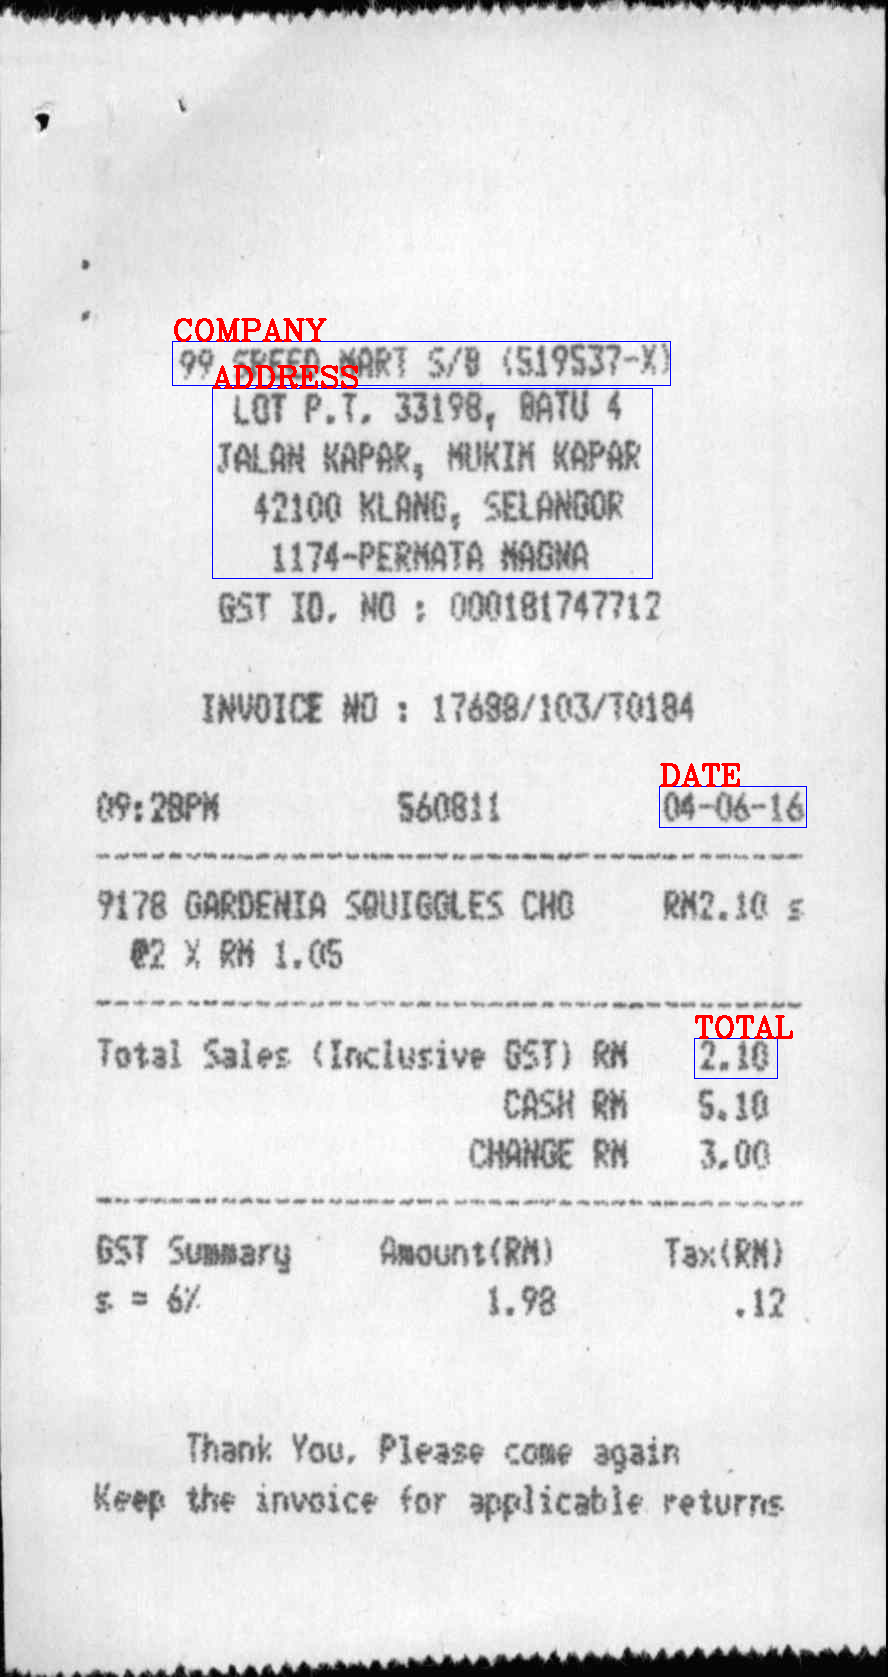

In [ ]:
import json
import cv2
from google.colab.patches import cv2_imshow

img=random.sample(os.listdir("/content/data/test/img"),1)
img_path=os.path.join("/content/data/test/img",img[0])
bbox_path=os.path.join("/content/out/bbox",img[0].replace("jpg","json"))
with open(bbox_path, "r", encoding="utf8") as f:
                data = json.load(f)
finalbox={}
for i in data.keys():
  a=[j[0] for j in data[i]]
  b=[j[2] for j in data[i]]
  finalbox[i]=[min(a),data[i][0][1],max(b),data[i][-1][3]]

img = cv2.imread(img_path)
img_size = img.shape
img_size = img_size[0]*img_size[1]
# read each coordinate and draw box
for d in finalbox:
            coor=finalbox[d]
            x1 = coor[0]
            y1 = coor[1]
            x3 = coor[2]
            y3 = coor[3]
            text_show = d.upper()
            #text_show = text + '(' + str(x1) + ',' + str(y1) +')'
            cv2.rectangle(img, (x1, y1), (x3, y3), (255, 0, 0), 1)
            cv2.putText(img, text_show, (x1, y1 - 1),
                      cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

#cv2.imwrite('1', img)
img = cv2_imshow(img)

# Prediction on unlabeled data ( test set of the competition )

In [ ]:
cd /content/

/content


In [ ]:
!gdown --id 19Td-gvy59oQro0sXBp6FWuqfQ1SoeDho
!unzip test.zip && mkdir testdata && mv SROIE/box testdata/box && mv SROIE/img testdata/img  && rm -rf test.zip SROIE

Downloading...
From: https://drive.google.com/uc?id=19Td-gvy59oQro0sXBp6FWuqfQ1SoeDho
To: /content/test.zip
208MB [00:02, 95.5MB/s]
Archive:  test.zip
  inflating: SROIE/img/X51008099047.jpg  
  inflating: SROIE/img/X51008042780.jpg  
  inflating: SROIE/img/X51008099100.jpg  
  inflating: SROIE/img/X51008030563.jpg  
  inflating: SROIE/img/X51007579714.jpg  
  inflating: SROIE/img/X51009447842.jpg  
  inflating: SROIE/img/X51007579719.jpg  
  inflating: SROIE/img/X51007391390.jpg  
  inflating: SROIE/img/X51008099086.jpg  
  inflating: SROIE/img/X51008099088.jpg  
  inflating: SROIE/img/X51007339127.jpg  
  inflating: SROIE/img/X51008042781.jpg  
  inflating: SROIE/img/X51008099090.jpg  
  inflating: SROIE/img/X51008042786.jpg  
  inflating: SROIE/img/X51008042787.jpg  
  inflating: SROIE/img/X51007579725.jpg  
  inflating: SROIE/img/X51008042779.jpg  
  inflating: SROIE/img/X51007339161.jpg  
  inflating: SROIE/img/X51007339122.jpg  
  inflating: SROIE/img/X51009008095.jpg  
  inflati

Because we don't have ground truth labels , we replace all words labels by other so that the model can accept it . That will result in score of 0 but we only need the predictions so that's okay

In [ ]:
def create_annotation_test(file_path,output):
  import json
  dict={}
  dict["form"]=[]
  with open(file_path, "r", encoding="utf8") as fb :
    id=0
    for line in fb :
      dict1={}
      line_split = line.strip().split(",", maxsplit=8)
      box=[line_split[0],line_split[1],line_split[4],line_split[5]]
      box=[int(i) for i in box]
      text = line_split[8]
      dict1["box"]=box
      dict1["text"]=text
      dict1["label"]="other"
      dict1["words"]=get_word_bbox(text,box)
      dict1["id"]=id
      id+=1
      dict["form"].append(dict1)

  with open(output, 'w',encoding='utf-8') as outfile:
    json.dump(dict, outfile,ensure_ascii=False, indent=4)



In [ ]:
import os
import re
import json
data_dir="testdata/box"
!mkdir testdata/annotations
for file in sorted(os.listdir(data_dir)):
           file_path = os.path.join(data_dir, file)
           output=file_path.replace("box", "annotations")
           output=output.replace("txt", "json")
           create_annotation_test(file_path,output)

In [ ]:
#modification de la fonction convert
def convert_test(output_dir,data_dir,data_split):
    with open(
        os.path.join(output_dir , data_split + ".txt.tmp"),
        "w",
        encoding="utf8",
    ) as fw, open(
        os.path.join(output_dir , data_split + "_box.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fbw, open(
        os.path.join(output_dir , data_split + "_image.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fiw:
        for file in sorted(os.listdir(data_dir)):
            file_path = os.path.join(data_dir, file)
            with open(file_path, "r", encoding="utf8") as f:
                data = json.load(f)
            image_path = file_path.replace("annotations", "img")
            image_path = image_path.replace("json", "jpg")
            file_name = os.path.basename(image_path)
            image = Image.open(image_path)
            width, length = image.size
            for item in data["form"]:
                words, label = item["words"], item["label"]
                words = [w for w in words if w["text"].strip() != ""]
                if len(words) == 0:
                    continue
                if label == "other":
                    for w in words:
                        fw.write(w["text"] + "\tO\n")
                        fbw.write(
                            w["text"]
                            + "\t"
                            + bbox_string(w["box"], width, length)
                            + "\n"
                        )
                        fiw.write(
                            w["text"]
                            + "\t"
                            + actual_bbox_string(item["box"], width, length)
                            + "\t"
                            + file_name
                            + "\n"
                        )
            fw.write("\n")
            fbw.write("\n")
            fiw.write("\n")

def seg_file(file_path, tokenizer, max_len):
    subword_len_counter = 0
    output_path = file_path[:-4]
    with open(file_path, "r", encoding="utf8") as f_p, open(
        output_path, "w", encoding="utf8"
    ) as fw_p:
        for line in f_p:
            line = line.rstrip()

            if not line:
                fw_p.write(line + "\n")
                subword_len_counter = 0
                continue
            token = line.split("\t")[0]

            current_subwords_len = len(tokenizer.tokenize(token))

            # Token contains strange control characters like \x96 or \x95
            # Just filter out the complete line
            if current_subwords_len == 0:
                continue

            if (subword_len_counter + current_subwords_len) > max_len:
                fw_p.write("\n" + line + "\n")
                subword_len_counter = current_subwords_len
                continue

            subword_len_counter += current_subwords_len

            fw_p.write(line + "\n")


def seg(model_name_or_path,output_dir,max_len,data_split):
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, do_lower_case=True)
    seg_file(
        os.path.join(output_dir, data_split + ".txt.tmp"),
        tokenizer,
        max_len,
    )
    seg_file(
        os.path.join(output_dir, data_split + "_box.txt.tmp"),
        tokenizer,
        max_len,
    )
    seg_file(
        os.path.join(output_dir, data_split + "_image.txt.tmp"),
        tokenizer,
        max_len,
    )



In [ ]:
data_dir="/content/testdata/annotations"
data_split="test"
output_dir="/content/testdata/"
model_name_or_path="bert-base-uncased"
max_len=512
convert_test(output_dir,data_dir,data_split)
seg(model_name_or_path,output_dir,max_len,data_split)

In [ ]:
!mkdir /content/testdata/out

In [ ]:
%cd /content/testdata/out/

/content/testdata/out


In [ ]:
!gdown --id 13qeDd-Odgys3RIotRKzZZ5Jc18H7Obm0
!unzip pytorch_model.zip && rm -rf pytorch_model.zip

Downloading...
From: https://drive.google.com/uc?id=13qeDd-Odgys3RIotRKzZZ5Jc18H7Obm0
To: /content/testdata/out/pytorch_model.zip
417MB [00:02, 183MB/s]
Archive:  pytorch_model.zip
  inflating: training_args.bin       
  inflating: tokenizer_config.json   
  inflating: special_tokens_map.json  
  inflating: pytorch_model.bin       
  inflating: config.json             
  inflating: vocab.txt               


In [ ]:
cd /content/unilm/layoutlm/examples/seq_labeling


/content/unilm/layoutlm/examples/seq_labeling


In [ ]:
%cp run_seq_labeling.py run_seq_labeling_test.py

***Because we have unlabeled data , I commented line 385 and 386 in  "run_seq_labeling_test.py" ( which give the classification report ) otherwise the model won't work***



In [ ]:
!python run_seq_labeling_test.py  --data_dir /content/testdata/ \
                            --model_type layoutlm \
                            --model_name_or_path /content/layoutlm-base-uncased \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --num_train_epochs 100.0 \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir /content/testdata/out \
                            --labels /content/data/labels.txt \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 8 \
                            --fp16

2020-09-23 21:23:24.834709: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Evaluating: 100% 44/44 [00:06<00:00,  6.72it/s]


In [ ]:
%cd /content/testdata/out/

/content/testdata/out


In [ ]:
import json
import os
!mkdir post
!mkdir box
key_dir="/content/testdata/annotations"
output_dir="/content/testdata/out/post"
box_out_dir="/content/testdata/out/box"
with open("/content/testdata/out/test_predictions.txt", "r", encoding="utf8") as f, open("/content/testdata/test_image.txt.tmp", "r", encoding="utf8") as fb:
  lines=f.readlines()
  blines=fb.readlines()
  i=0
  for file in sorted(os.listdir(key_dir)):
    outpath=os.path.join(output_dir,file.replace(".json",".txt"))
    boxpath=os.path.join(box_out_dir,file.replace(".json",".txt"))
    with open(outpath,'w',encoding="utf8") as fw , open(boxpath,'w',encoding="utf8") as fbw :
      while lines[i] !="\n" :
        fw.write(lines[i])
        fbw.write(blines[i])
        i+=1
    fw.close()
    fbw.close()
    i+=1
f.close()
fbw.close()

In [ ]:
!mkdir key
!mkdir bbox
dir="/content/testdata/out/post"
out_dir="/content/testdata/out/key"
box_dir="/content/testdata/out/box"
box_out_dir="/content/testdata/out/bbox"

for file in sorted(os.listdir(dir)):
  file_path=os.path.join(dir,file)
  box_path=os.path.join(box_dir,file)
  with open(file_path,'r',encoding="utf8") as f , open(box_path,'r',encoding="utf8") as fb :
    dict={}
    boxdict={}
    lines=f.readlines()
    blines=fb.readlines()
    i=0
    while i != len(lines) :
      words=lines[i].strip().split(" ")
      bwords=blines[i].strip().split("\t")
      box=[int(i) for i in bwords[1].strip().split(" ")]
      if words[1][0]=='O':
        i+=1
      elif words[1][0]=="I":
        i+=1
      elif words[1][0]=='B' :
        entity=words[1][2:].lower()
        new=[words[0]]
        boxdict[entity]=[box]
        i+=1
        if i!= len(lines):
          next=lines[i].strip().split(" ")
          bnext=blines[i].strip().split("\t")
          bxnext=[int(i) for i in bnext[1].strip().split(" ")]
        while next[1][0]=='I':
          new.append(next[0])
          if bxnext not in boxdict[entity] :
            boxdict[entity].append(bxnext)
          i+=1
          next=lines[i].strip().split(" ")
          bnext=blines[i].strip().split("\t")
          bxnext=[int(i) for i in bnext[1].strip().split(" ")]
        dict[entity]=new
  out={}
  outb={}
  for i in dict.keys():
    if i=="total" and len(boxdict[i])>1 :
      outb[i]=[boxdict[i][-2]]
      out[i]=' '.join(dict[i][0])
    elif i=="date" and len(boxdict[i])>1 :
      outb[i]=[boxdict[i][0]]
      out[i]=' '.join(dict[i])
    else:
      out[i]=' '.join(dict[i])
      outb[i]=boxdict[i]

  out_path=os.path.join(out_dir,file.replace("txt","json"))
  outb_path=os.path.join(box_out_dir,file.replace("txt","json"))
  with open(out_path, 'w',encoding='utf-8') as outfile:
     json.dump(out, outfile,ensure_ascii=False, indent=4)
  with open(outb_path, 'w',encoding='utf-8') as outfile:
     json.dump(outb, outfile,ensure_ascii=False, indent=4)

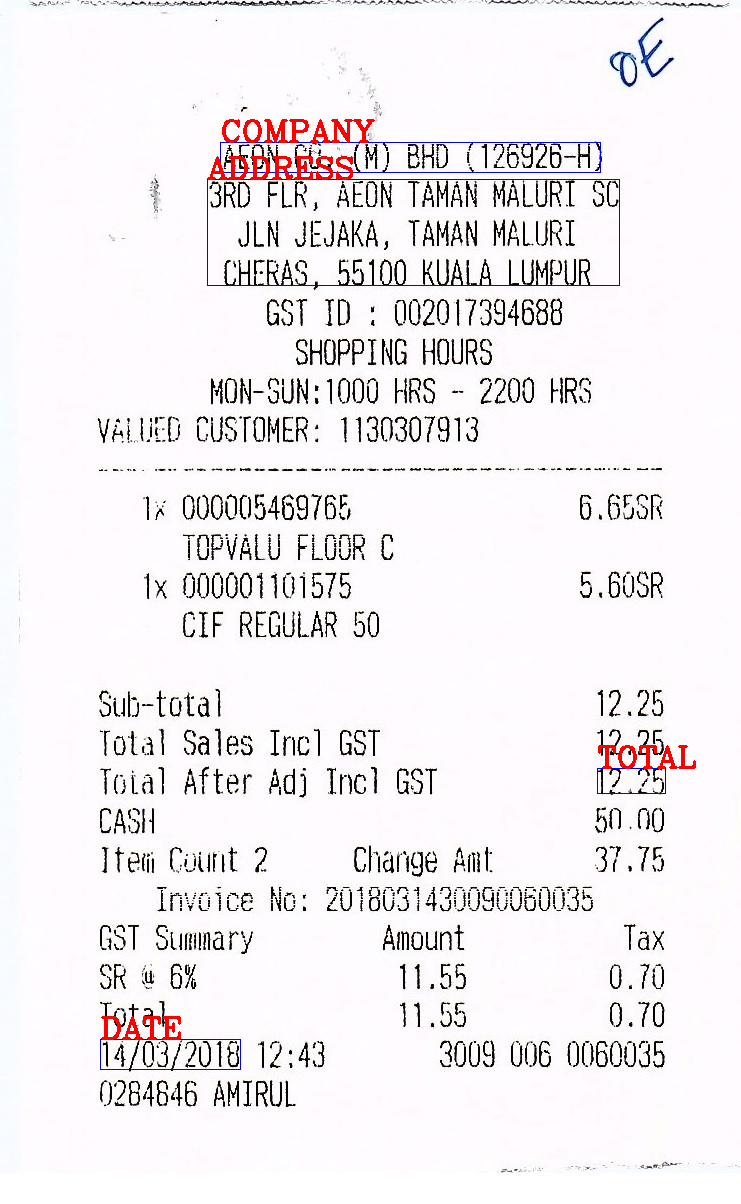

In [ ]:
import json
import cv2
from google.colab.patches import cv2_imshow

img=random.sample(os.listdir("/content/testdata/img"),1)
img_path=os.path.join("/content/testdata/img",img[0])
bbox_path=os.path.join("/content/testdata/out/bbox",img[0].replace("jpg","json"))
with open(bbox_path, "r", encoding="utf8") as f:
                data = json.load(f)
finalbox={}
for i in data.keys():
  a=[j[0] for j in data[i]]
  b=[j[2] for j in data[i]]
  finalbox[i]=[min(a),data[i][0][1],max(b),data[i][-1][3]]

img = cv2.imread(img_path)
img_size = img.shape
img_size = img_size[0]*img_size[1]
# read each coordinate and draw box
for d in finalbox:
            coor=finalbox[d]
            x1 = coor[0]
            y1 = coor[1]
            x3 = coor[2]
            y3 = coor[3]
            text_show = d.upper()
            #text_show = text + '(' + str(x1) + ',' + str(y1) +')'
            cv2.rectangle(img, (x1, y1), (x3, y3), (255, 0, 0), 1)
            cv2.putText(img, text_show, (x1, y1 - 1),
                      cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

#cv2.imwrite('1', img)
img = cv2_imshow(img)